# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [28]:
file_path = '../data/treasury_quotes_2024-10-31.xlsx'
selected_quotes = pd.read_excel(file_path, sheet_name='selected quotes')
df = selected_quotes
df.set_index("KYTREASNO", inplace=True)
df

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208042,note,2024-10-31,2023-04-30,2025-04-30,0.495551,0,3.875,99.712500,99.722203,99.717351,0,99.717351,0.044933
208129,note,2024-10-31,2023-10-31,2025-10-31,0.999316,0,5.000,100.641406,100.660819,100.651113,0,100.651113,0.043311
208213,note,2024-10-31,2024-04-30,2026-04-30,1.494867,0,4.875,100.929688,100.960938,100.945312,0,100.945312,0.042327
208302,note,2024-10-31,2024-10-31,2026-10-31,1.998631,0,4.125,99.933594,99.941406,99.937500,0,99.937500,0.041611
207875,note,2024-10-31,2022-04-30,2027-04-30,2.494182,0,2.750,96.750000,96.781250,96.765625,0,96.765625,0.041346
207960,note,2024-10-31,2022-10-31,2027-10-31,2.997947,0,4.125,99.992188,100.015625,100.003906,0,100.003906,0.041268
208044,note,2024-10-31,2023-04-30,2028-04-30,3.496235,0,3.500,97.902344,97.941406,97.921875,0,97.921875,0.041487
208132,note,2024-10-31,2023-10-31,2028-10-31,4.000000,0,4.875,102.585938,102.621094,102.603516,0,102.603516,0.041623
208216,note,2024-10-31,2024-04-30,2029-04-30,4.495551,0,4.625,101.894531,101.929688,101.912109,0,101.912109,0.041590


### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [29]:
def get_coupon_dates(quote_date, maturity_date):
    quote_date = pd.to_datetime(quote_date)
    maturity_date = pd.to_datetime(maturity_date)
    coupon_dates = pd.date_range(start=quote_date, end=maturity_date, freq=DateOffset(months=6))
    coupon_dates = coupon_dates[coupon_dates > quote_date]
    return coupon_dates

def create_cashflow_matrix(quotes):
    quotes = quotes[~quotes['type'].isin(['TIPS Note', 'TIPS bond'])].copy()
    quotes['quote date'] = pd.to_datetime(quotes['quote date'])
    quotes['maturity date'] = pd.to_datetime(quotes['maturity date'])
    ref_date = quotes['quote date'].iloc[0]
    cf_dict = {}
    all_dates = set()
    for i, row in quotes.iterrows():
        maturity = row['maturity date']
        coupon_rate = row['cpn rate']
        coupon_payment = coupon_rate / 2
        coupon_dates = get_coupon_dates(ref_date, maturity)
        cashflows = {}
        for d in coupon_dates:
            cashflows[d] = coupon_payment
            all_dates.add(d)
        if maturity in cashflows:
            cashflows[maturity] += 100
        else:
            cashflows[maturity] = 100
            all_dates.add(maturity)
        cf_dict[i] = cashflows
    all_dates = sorted(all_dates)
    CF = pd.DataFrame(0, index=quotes.index, columns=all_dates)
    for i, cashflows in cf_dict.items():
        for d, amount in cashflows.items():
            CF.loc[i, d] = amount
    CF = CF.resample('M', axis=1).sum()
    CF = CF.loc[:, (CF != 0).any()]
    CF = CF.fillna(0).sort_index(axis=1)
    return CF

In [30]:
CF = create_cashflow_matrix(df)
CF

,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [31]:
def discount_to_intrate(discount, maturity, n_compound=2):
    return n_compound * (discount ** (-1/(n_compound * maturity)) - 1)

def estimate_spot_factors(CF, quotes, n_compound=2):
    prices = quotes['price'].loc[CF.index].values
    discount_factors = np.linalg.solve(CF.values, prices)
    spot = pd.DataFrame(discount_factors, index=CF.index, columns=['discount factor'])
    spot.insert(0, 'ttm', quotes['ttm'])
    spot = spot.reset_index(drop=True).set_index('ttm')
    spot['rate'] = discount_to_intrate(spot['discount factor'], spot.index.values, n_compound=n_compound)
    return spot

,discount factor,rate
ttm,,
0.495551,0.978220,0.044933
0.999316,0.958103,0.043291
1.494867,0.939358,0.042290
1.998631,0.921067,0.041565
2.494182,0.903034,0.041314
2.997947,0.884856,0.041224
3.496235,0.866327,0.041466
4.000000,0.848120,0.041610
4.495551,0.831110,0.041576


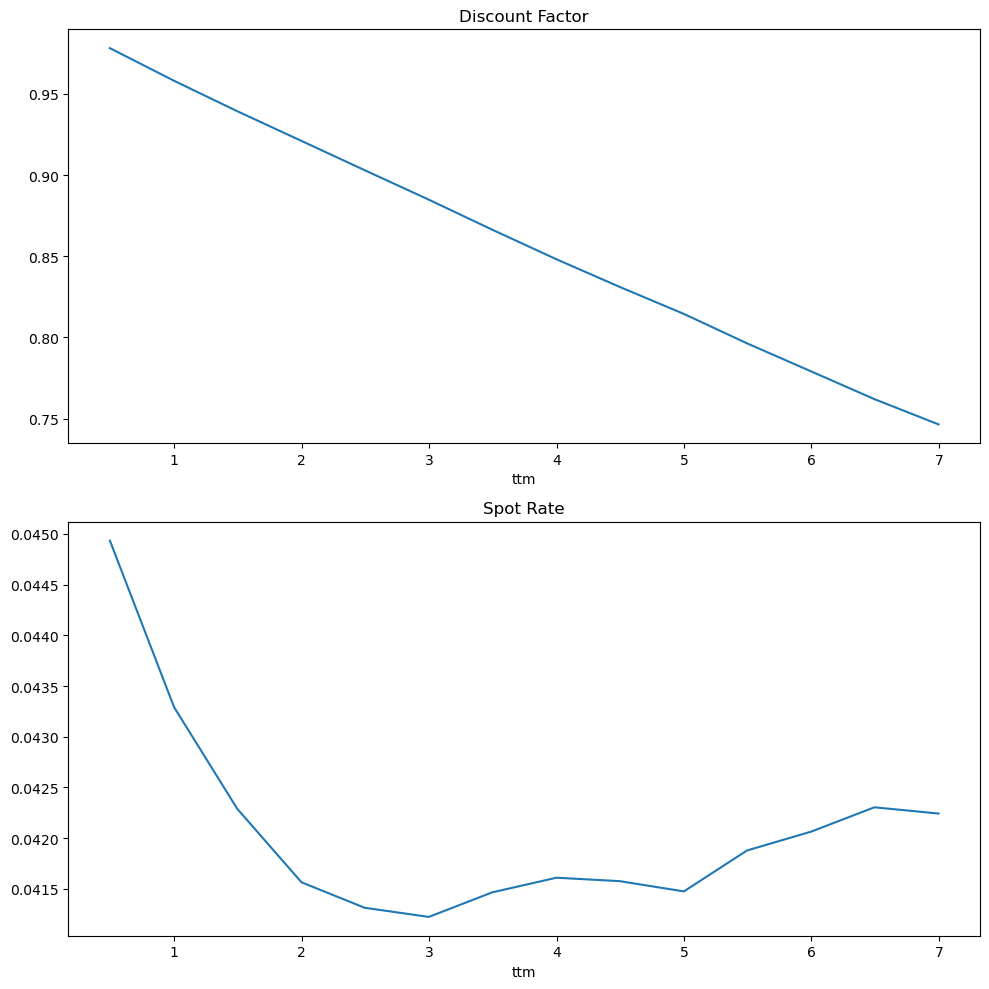

In [32]:
spot = estimate_spot_factors(CF, selected_quotes, n_compound=2)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
spot['discount factor'].plot(ax=ax[0], title='Discount Factor')
spot['rate'].plot(ax=ax[1], title='Spot Rate')
display(spot)
plt.tight_layout()
plt.show()

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

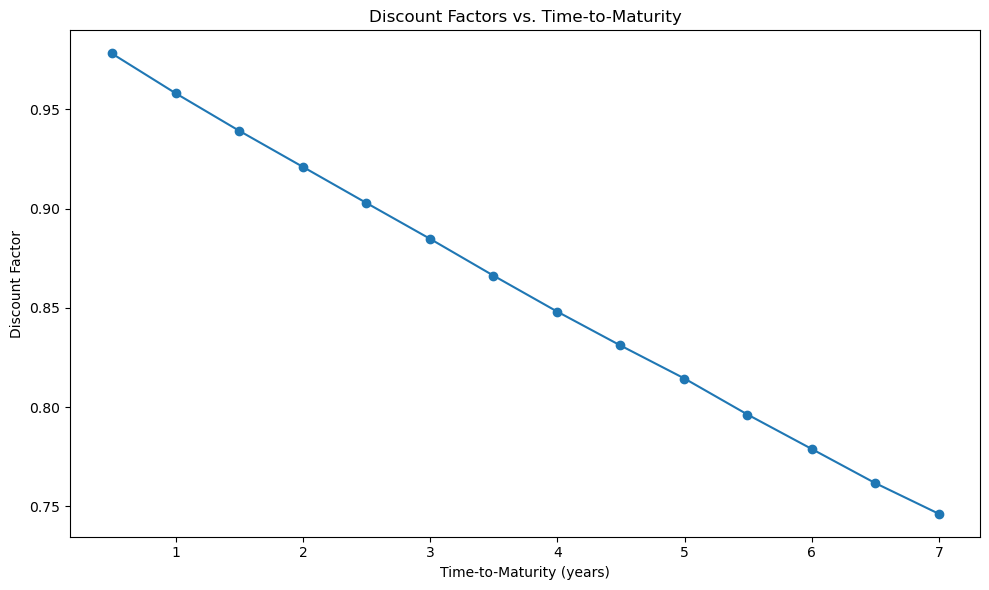

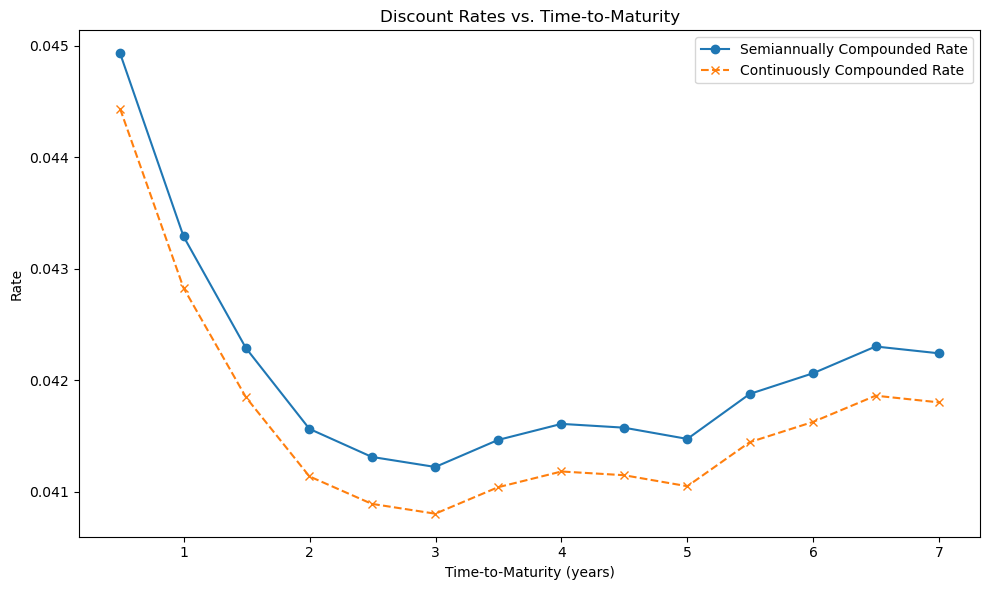

In [39]:
def intrate_to_discount(intrate, maturity, n_compound=2):
    return 1 / (1 + intrate/n_compound)**(n_compound * maturity)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spot.index, spot['discount factor'], marker='o', linestyle='-')
ax.set_xlabel('Time-to-Maturity (years)')
ax.set_ylabel('Discount Factor')
ax.set_title('Discount Factors vs. Time-to-Maturity')
plt.tight_layout()
plt.show()

semiannual_rates = spot['rate']
continuous_rates = -np.log(spot['discount factor']) / spot.index.values

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spot.index, semiannual_rates, marker='o', linestyle='-', label='Semiannually Compounded Rate')
ax.plot(spot.index, continuous_rates, marker='x', linestyle='--', label='Continuously Compounded Rate')
ax.set_xlabel('Time-to-Maturity (years)')
ax.set_ylabel('Rate')
ax.set_title('Discount Rates vs. Time-to-Maturity')
ax.legend()
plt.tight_layout()
plt.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [40]:
COMPOUNDING = 2
rADJ = 0.005
CFadj = CF + rADJ/2 * 100 * (CF > 0)
discadj = spot['rate'] + rADJ
spot['discount adjusted'] = intrate_to_discount(discadj, spot.index.values, n_compound=COMPOUNDING)
pxadj = pd.DataFrame(CFadj.values @ spot[['discount adjusted']].values, index=CFadj.index, columns=['price adjusted'])
px = selected_quotes['dirty price'].loc[pxadj.index]
price_comp = pd.concat([px, pxadj], axis=1)
price_comp.style.format('{:.2f}')
display(price_comp)

,dirty price,price adjusted
KYTREASNO,,
208042,99.717351,99.720256
208129,100.651113,100.648984
208213,100.945312,100.942717
208302,99.937500,99.937669
207875,96.765625,96.790333
207960,100.003906,100.003602
208044,97.921875,97.942614
208132,102.603516,102.575685
208216,101.912109,101.891044


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

In [42]:
DATE = '2024-10-31'
filepath = f'../data/treasury_quotes_{DATE}.xlsx'
quotes = pd.read_excel(filepath, sheet_name='quotes').set_index('KYTREASNO')
quotes['quote date'] = pd.to_datetime(quotes['quote date'])
quotes['maturity date'] = pd.to_datetime(quotes['maturity date'])
quotes

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.000,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.000,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.000,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.000,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.500,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208149,bond,2024-10-31,2023-11-15,2053-11-15,29.040383,0.918478,4.750,104.281250,104.335938,104.308594,2.181386,106.489980,0.044837
208191,TIPS note,2024-10-31,2024-02-15,2054-02-15,29.292266,0.000000,2.125,98.965129,99.137004,99.051066,0.000000,99.051066,NaN
208178,bond,2024-10-31,2024-02-15,2054-02-15,29.292266,0.418478,4.250,96.125000,96.171875,96.148438,0.889266,97.037704,0.044873


### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import DateOffset

def get_coupon_dates_backward(quote_date, maturity_date):
    quote_date = pd.to_datetime(quote_date)
    maturity_date = pd.to_datetime(maturity_date)
    coupon_dates = []
    current_date = maturity_date
    while current_date > quote_date:
        coupon_dates.append(current_date)
        current_date -= DateOffset(months=6)
    coupon_dates.sort()
    return coupon_dates

def calc_cashflows(quotes):
    cf_dict = {}
    all_dates = set()
    for i, row in quotes.iterrows():
        maturity = row['maturity date']
        coupon_rate = row['cpn rate']
        coupon_payment = coupon_rate / 2
        coupon_dates = get_coupon_dates_backward(row['quote date'], maturity)
        cashflows = {}
        for d in coupon_dates:
            cashflows[d] = coupon_payment
            all_dates.add(d)
        if maturity in cashflows:
            cashflows[maturity] += 100
        else:
            cashflows[maturity] = 100
            all_dates.add(maturity)
        cf_dict[i] = cashflows
    all_dates = sorted(all_dates)
    CF = pd.DataFrame(0, index=quotes.index, columns=all_dates)
    for i, cashflows in cf_dict.items():
        for d, amount in cashflows.items():
            CF.loc[i, d] = amount
    return CF


In [52]:
quotes = quotes[quotes['ytm'].notnull() & (quotes['ytm'] >= 0)]

CF = calc_cashflows(quotes)
CF = CF.loc[:, (CF != 0).any(axis=0)]

display(CF)

largest_sum_column = CF.sum().idxmax()
most_nonzero_column = (CF != 0).sum().idxmax()

print(f"Date paying the most cash: {largest_sum_column:%Y-%m-%d}")
print(f"Date with the most paying bonds: {most_nonzero_column:%Y-%m-%d}")

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208222,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208247,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208223,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
204083,0,0,0,0,103.7500,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0,0,0,0,2.3750,0,0,0,0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000


Date paying the most cash: 2025-02-15
Date with the most paying bonds: 2025-02-15


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

KeyError: 'CALDT'

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.


In [28]:
file_path = '../data/yields.xlsx'
yields_df = pd.read_excel(file_path, sheet_name='yields')
yields_df

,caldt,1,2,5,7,10,20,30
0,1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1,1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
2,1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
3,1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
4,1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018
...,...,...,...,...,...,...,...,...
15718,2024-05-24,5.151637,4.876767,4.477900,4.422071,4.413264,4.641009,4.513753
15719,2024-05-28,5.149635,4.921106,4.550730,4.512302,4.498891,4.737532,4.612964
15720,2024-05-29,5.231355,4.933358,4.603891,4.566732,4.561608,4.802605,4.679462
15721,2024-05-30,5.174662,4.884783,4.537826,4.496453,4.496618,4.744930,4.625810


### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [48]:
maturities = list(map(int, yields_df.columns[1:]))

factors = pd.DataFrame(index=yields_df.index)
factors['level'] = yields_df[maturities].mean(axis=1)
factors['slope'] = yields_df[30] - yields_df[1]
factors['curvature'] = -yields_df[1] + 2*yields_df[10] - yields_df[30]
factors.head()

,level,slope,curvature
0,3.591027,0.879264,0.886559
1,3.614691,0.893380,0.966721
2,3.617360,0.900101,0.966566
3,3.630646,0.916659,1.013983
4,3.627267,0.892599,0.975574


In [49]:
correlation_matrix = factors.corr()
correlation_matrix

,level,slope,curvature
level,1.000000,-0.375967,-0.169325
slope,-0.375967,1.000000,0.647671
curvature,-0.169325,0.647671,1.000000


In [53]:
mean_factors = factors.mean()
mean_factors.to_frame().rename(columns={0:"Mean Factors"})

,Mean Factors
level,5.475250
slope,1.109788
curvature,0.671817


In [54]:
vol_factors = factors.std()
vol_factors.to_frame().rename(columns={0:"Vol Factors"})

,Vol Factors
level,2.914725
slope,1.480255
curvature,0.971945


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [67]:
pca = PCA() 
pca.fit(yields_df[yields_df.columns[1:]])

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio by each component):")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio}\n")

cumulative_ratio = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance Ratio:")
for i, ratio in enumerate(cumulative_ratio, ):
    print(f"Till PC{i+1}: {ratio}\n")

Explained Variance Ratio by each component):
PC1: 0.970700015166877

PC2: 0.025278256947983514

PC3: 0.0029470210113299662

PC4: 0.000454237470931134

PC5: 0.00037174834268467174

PC6: 0.0001518220034797486

PC7: 9.689905671397735e-05

Cumulative Explained Variance Ratio:
Till PC1: 0.970700015166877

Till PC2: 0.9959782721148605

Till PC3: 0.9989252931261904

Till PC4: 0.9993795305971215

Till PC5: 0.9997512789398062

Till PC6: 0.9999031009432859

Till PC7: 0.9999999999999999



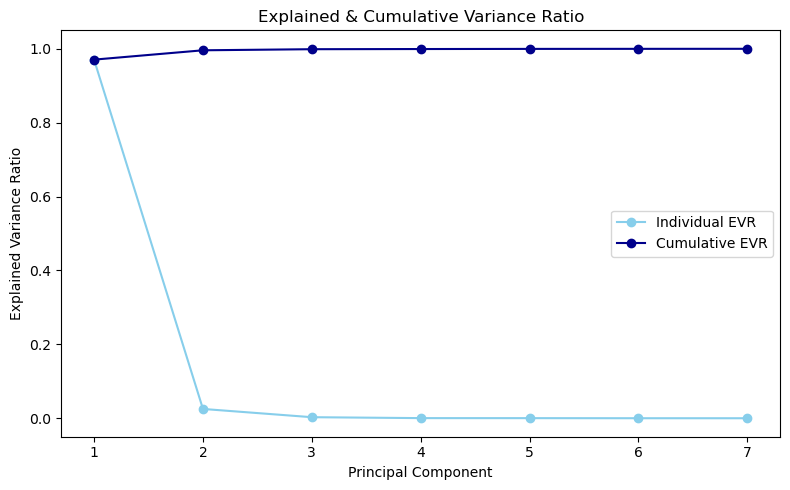

In [68]:
x_axis = np.arange(1, len(explained_variance_ratio) + 1)
plt.figure(figsize=(8, 5))
plt.plot(x_axis, explained_variance_ratio, marker='o', linestyle='-', color='skyblue', 
         label='Individual EVR')
plt.plot(x_axis, cumulative_ratio, marker='o', linestyle='-', color='darkblue', 
         label='Cumulative EVR')

plt.xticks(x_axis) 
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained & Cumulative Variance Ratio')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
import seaborn as sns
loadings_pc1 = pca.components_[0]
loadings_pc2 = pca.components_[1]
loadings_pc3 =  pca.components_[2]
loadings_df = pd.DataFrame(
    [loadings_pc1, loadings_pc2, loadings_pc3],
    index=['PC1', 'PC2', 'PC3'],
    columns=yields_df.columns[1:]  
)
loadings_df

,1,2,5,7,10,20,30
PC1,0.411464,0.411054,0.392784,0.378353,0.363380,0.344069,0.337450
PC2,-0.591006,-0.399298,-0.046806,0.087439,0.202674,0.438856,0.497760
PC3,0.455496,0.007324,-0.392437,-0.448402,-0.363501,0.363015,0.416516


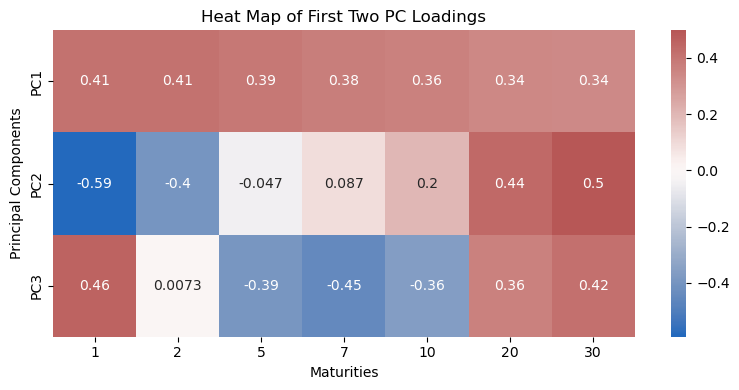

In [73]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    loadings_df, 
    annot=True,       
    cmap='vlag',      
    center=0
)
plt.title('Heat Map of First Two PC Loadings')
plt.ylabel('Principal Components')
plt.xlabel('Maturities')
plt.tight_layout()
plt.show()

### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [77]:
compare_df = pd.concat([factors[['level', 'slope', 'curvature']], loadings_df.T[['PC1', 'PC2', 'PC3']]], axis=1)

corr_matrix = compare_df.corr()
corr_matrix

,level,slope,curvature,PC1,PC2,PC3
level,1.000000,-0.375967,-0.169325,0.067732,0.081878,-0.888205
slope,-0.375967,1.000000,0.647671,-0.697979,0.719813,-0.347836
curvature,-0.169325,0.647671,1.000000,0.653764,-0.564783,-0.682504
PC1,0.067732,-0.697979,0.653764,1.000000,-0.972211,-0.194414
PC2,0.081878,0.719813,-0.564783,-0.972211,1.000000,-0.001032
PC3,-0.888205,-0.347836,-0.682504,-0.194414,-0.001032,1.000000


In [78]:
corr_level_pc1 = corr_matrix.loc['level', 'PC1']
corr_slope_pc2 = corr_matrix.loc['slope', 'PC2']

print(f"Correlation (Ad-hoc level, PC1): {corr_level_pc1:.4f}")
print(f"Correlation (Ad-hoc slope, PC2): {corr_slope_pc2:.4f}")

Correlation (Ad-hoc level, PC1): 0.0677
Correlation (Ad-hoc slope, PC2): 0.7198
